####  フィードフォワードプロパゲーション

入力データ(A)を重み(W)と掛けて(Z)活性化関数により活性化(次のA)して…を順方向に繰り返し、出力を得る<br>

* 入力ユニット $A^{(1)} \cdots$ サンプル数 x (次元数 + 1)
* 入力層から隠れ層への重み $W^{(1)} \cdots$ 隠れ層のユニット数 x (次元数 + 1)
* 隠れ層への総入力ベクトル $Z^{(1)} = W^{(1)} [A^{(1)}]^T\cdots$ 隠れ層のユニット数 x サンプル数
* 隠れ層から出力層への入力ユニット $A^{(2)} = \phi(Z^{(1)})\cdots$ 隠れ層のユニット数 x サンプル数
* 隠れ層から出力層への重み $W^{(2)} \cdots$ 出力のパターン数 x 隠れ層のユニット数
* 出力層への総入力ベクトル $Z^{(2)} = W^{(2)}A^{(2)}\cdots$ 出力のパターン数 x サンプル数
* 出力層からの出力 $A^{(3)} = \phi(Z^{(2)})\cdots$ 出力のパターン数 x サンプル数

#### 活性化関数

$$
\phi(z) = \frac{1}{1 + e^{(-z)}} \cdots 配列を入力した場合は全ての要素に対して同じ計算をする
$$

#### バックプロパゲーション

1. サンプル毎に出力層の各ユニット（数字当てなら0〜9までの数字のパターンに対応するユニット）毎の出力と、正解データとの２乗誤差をとり、<br>
全サンプルについて合計する<br>
→これが、最小化すべきコスト関数E(※1)
2. コスト関数Eを勾配法(※2)で0に近づけるためパラメータである、各重み毎の偏導関数$\frac{\partial E}{\partial w^{(l)}_{i,j}}$を計算する<br>
その際、合成関数の偏微分公式(※3)を用いる<br>
3. ここで、任意の層番号をl、ユニット番号をkとしたとき、$\delta^{(l)}_k$を$\frac{\partial E}{\partial \sum^{}_{j=1}w^{(l)}_{k,j}a^{(l-1)}_{j}}$と定義すると、<br>各重み毎の偏導関数を用いた、重みの更新式は以下のように表せる<br>
$$
w^{(l)}_{i,j} \gets w^{(l)}_{i,j} - \rho \frac{\partial E}{\partial w^{(l)}_{i,j}} = w^{(l)}_{i,j} - \rho \delta^{(l)}_i a^{(l-1)}_{j} 
$$
なお、多層パーセプトロンでは、出力層とそれ以外の層では$\delta^{(l)}_i$が以下のように異なる
$$
\delta^{(l)}_i = 
\left\{
  \begin{array}{ll}
    (a^{(l)}_i - t_i)f'(\sum^{}_{j=1}w^{(l)}_{i,j}a^{(l-1)}_{j}) & (l=L) \\
    \sum_k \delta^{(l+1)}_k w^{(l+1)}_{k+1} f'(\sum^{}_{j=1}w^{(l)}_{i,j}a^{(l-1)}_{j}) & (l < L)
  \end{array}
\right.
$$
4. 出力層以外では、上記の通り、ひとつ先（現在の層の番号＋１）の層の計算結果が更新式に含まれる<br>
従って、出力層から入力層方向に計算をすすめることで、１つ前に計算した結果を流用し、効率化することができる

##### ※2 勾配法

ある関数の一階導関数を得て、逆方向（傾きが＋ならー方向、ーなら＋方向）にすすめることにより、極小値に近づく方法

##### ※3 合成関数の偏微分公式（連鎖律）

$a = f(b_1, b_2, b_3, \cdots, b_n)$で、かつ$b_n = g(c)$のとき、<br>
$$
\frac{\partial a}{\partial c} = \sum^{n}_{k=1}\frac{\partial a}{\partial b_k}\frac{\partial b_k}{\partial c}
$$

参考1）<br>
http://hokuts.com/2016/05/27/pre-bp/<br>
http://hokuts.com/2016/05/29/bp1/<br>
http://hokuts.com/2016/10/09/bp2/<br>

##### ※1 コスト関数

例えばロジスティック回帰の場合、コストは尤度関数を対数化した対数尤度関数にマイナスを掛けたもの<br>
$$
l(w) = log(\prod^{n}_{i=1}(\phi(z^{(i)}))^{y^{(i)}}(1-\phi(z^{(i)})^{1-y^{(i)}} )= \sum^{n}_{i=1}[y^{(i)}log(\phi(z^{(i)})) + (1 - y^{(i)})log(1 - \phi(z^{(i)}))]
$$
iはサンプルの番号

In [1]:
# データ読み込み
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    """MNISTデータをpathからロードする"""
    # 引数に渡したパスとファイル名を結合し、フルパスを生成
    labels_path = os.path.join(path, '%s-labels-idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images-idx3-ubyte' % kind)
    
    # ラベルファイル読み込み
    # openにファイルパスとバイナリ読み込みモード指定
    with open(labels_path, 'rb') as lbpath:
        # unpackでバイナリを文字列に変換 先頭8バイトはマジックナンバーとアイテムの個数
        magic, n = struct.unpack('>II', lbpath.read(8))
        # fromfileで配列のデータ形式を指定して配列を作成
        labels = np.fromfile(lbpath, dtype=np.uint8)
        
    # 画像ファイル読み込み
    # 構造：サンプル数 ×　グレースケールの輝度（28×28=784次元）
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
        
    return images, labels

In [2]:
# データ読み込み
X_train, y_train = load_mnist('mnist')
print('Rows: %d, columns: %d' % (X_train.shape[0], X_train.shape[1]))

X_test, y_test = load_mnist('mnist', kind='t10k')
print('Rows: %d, columns: %d' % (X_test.shape[0], X_test.shape[1]))

Rows: 60000, columns: 784
Rows: 10000, columns: 784


In [3]:
y_train.shape

(60000,)

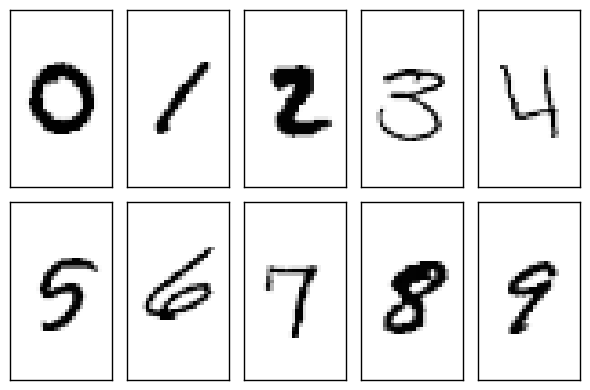

In [10]:
# imageを表示
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

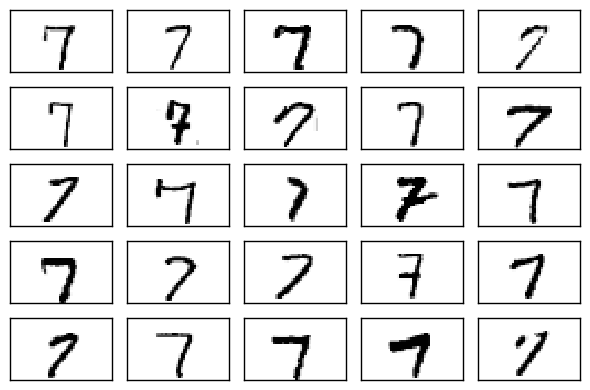

In [11]:
# imageを表示2
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [6]:
# 多層パーセプトロンを実装する

import numpy as np
from scipy.special import expit # シグモイド関数 1.0 / (1.0 + np.exp(-z)) に等しい
import sys

class NeuralNetMLP(object):
    
    # 初期化
    def __init__(self, n_output, n_features, n_hidden=30, l1=0.0, l2=0.0, epochs=500, eta=0.001, alpha=0.0,
                  decrease_const=0.0, shuffle=True, minibatches=1, random_state=None, debug=False):
        np.random.seed(random_state)
        self.n_output = n_output                      # 出力ユニット数
        self.n_features = n_features                  # 入力ユニット数
        self.n_hidden = n_hidden                      # 隠れ層のユニット数
        self.w1, self.w2 = self._initialize_weights() # 重みを初期化
        self.l1 = l1                                  # L1正則化のλパラメータ
        self.l2 = l2                                  # L2正則化のλパラメータ
        self.epochs = epochs                          # トレーニング回数
        self.eta = eta                                # 学習率の初期値
        self.alpha = alpha                            # モーメンタム学習における一つ前の勾配に掛ける係数
        self.decrease_const = decrease_const          # 学習率etaの減衰率
        self.shuffle = shuffle                        # トレーニングごとにデータをシャッフルするか
        self.minibatches = minibatches                # 各トレーニングでのミニバッチ数
        self.debug = debug                            # 勾配のデバッグモードを有効にするかどうか
        
    # 重みの初期化
    def _initialize_weights(self):
        w1 = np.random.uniform(-1.0, 1.0, size=self.n_hidden * (self.n_features + 1)) 
        w1 = w1.reshape(self.n_hidden, self.n_features + 1) # h x (m + 1)
        w2 = np.random.uniform(-1.0, 1.0, size=self.n_output * (self.n_hidden + 1)) 
        w2 = w2.reshape(self.n_output, self.n_hidden + 1) # t x (h + 1)
        
        return w1, w2
    
    # 活性化関数
    def _sigmoid(self, z):
        return expit(z)
    
    # 活性化関数の勾配（偏導関数）
    def _sigmoid_gradient(self, z):
        sg = self._sigmoid(z)
        return sg * (1 - sg)
    
    # インプット用配列にバイアスユニットを追加する
    def _add_bias_unit(self, X, how='column'):
        if how == 'column':
            X_new = np.ones((X.shape[0], X.shape[1] + 1)) # 列を追加
            X_new[:, 1:] = X                              # 2列め以降にもとの配列を代入
        elif how == 'row':
            X_new = np.ones((X.shape[0] + 1, X.shape[1])) # 行を追加
            X_new[1:, :] = X                              # 2行め以降にもとの配列を代入
        else:
            raise AttributeError('`how` must be `column` or `row`')
        return X_new
    
    # フィードフォワード
    def _feedforward(self, X, w1, w2):
        a1 = self._add_bias_unit(X, how='column') # 入力 n x (m+1)
        z2 = w1.dot(a1.T)                         # 重みをかける h x (m+1) * (m+1) x n = h x n
        a2 = self._sigmoid(z2)                    # 活性化 h x n
        a2 = self._add_bias_unit(a2, how='row')   # (h+1) x n
        z3 = w2.dot(a2)                           # 重みをかける t x (h+1) * (h+1) x n = t x n
        a3 = self._sigmoid(z3)                    # 活性化 t x n
        return a1, z2, a2, z3, a3
    
    # L2ペナルティ項の係数
    def _L2_reg(self, lambda_, w1, w2):
        return (lambda_ / 2.0) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))
    
    # L1ペナルティ項の係数
    def _L1_reg(self, lambda_, w1, w2):
        return (lambda_ / 2.0) * (np.abs(w1[:, 1:]).sum() + np.abs(w2[:, 1:]).sum())
    
    # コスト計算 (対数尤度に-をかける)
    def _get_cost(self, y_enc, output, w1, w2):
        term1 = -y_enc * (np.log(output))
        term2 = (1 - y_enc) * np.log(1 - output)
        cost = np.sum(term1 - term2)
        L1_term = self._L1_reg(self.l1, w1, w2)
        L2_term = self._L2_reg(self.l2, w1, w2)
        cost = cost + L1_term + L2_term
        return cost
    
    # 重みの勾配を得る
    def _get_gradient(self, a1, a2, a3, z2, y_enc, w1, w2):
        # バックプロパゲーション
        sigma3 = a3 - y_enc                                    # 出力層の誤差ベクトル t(ターゲット数) x n(サンプル数)
        z2 = self._add_bias_unit(z2, how='row')                # (h+1) x n
        sigma2 = w2.T.dot(sigma3) * self._sigmoid_gradient(z2) # (h+1) x t * t x n X (h+1) x n
        sigma2 = sigma2[1:, :]                                 # 1行めがバイアス項なので除く-> h x (m+1)
        grad1 = sigma2.dot(a1)                                 # w1用の勾配 h x n * n x (m+1) = h x (m+1)
        grad2 = sigma3.dot(a2.T)                               # w2用の勾配 t x n * n x (h+1) = t x (h+1)
        # 正則化
        grad1[:, 1:] += (w1[:, 1:] * (self.l1 + self.l2))      # 1列めはバイアス項
        grad2[:, 1:] += (w2[:, 1:] * (self.l1 + self.l2))      # 1列めはバイアス項
        return grad1, grad2
    
    # 出力層のエンコード
    def _encode_labels(self, y, n_output_patterns):
        onehot = np.zeros((n_output_patterns, y.shape[0]))  # y.shape[0] はサンプル数
        for idx, val in enumerate(y):
            onehot[val, idx] = 1.0
        return onehot                             # 出力は t(出力パターン0〜9) x n(サンプル数)
    
    # モデルをデータにfitさせる
    def fit(self, X, y, print_progress=True):
        self.cost_ = []
        X_data, y_data = X.copy(), y.copy()
        y_enc = self._encode_labels(y, self.n_output)
        delta_w1_prev = np.zeros(self.w1.shape)
        delta_w2_prev = np.zeros(self.w2.shape)
        for i in range(self.epochs):
            # 学習率を減衰させる
            self.eta /= (1 + self.decrease_const * i)
            if print_progress:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
            if self.shuffle: # アルゴリズムが循環しないよう、データセットをシャッフル
                idx = np.random.permutation(y_data.shape[0])
                X_data, y_enc = X_data[idx], y_enc[:, idx]
            mini = np.array_split(range(y_data.shape[0]), self.minibatches) # 学習を加速させるためにミニバッチ毎に勾配を計算
            for idx in mini:
                # フィードフォワード
                a1, z2, a2, z3, a3 = self._feedforward(X_data[idx], self.w1, self.w2)
                # 出力からコストを計算
                cost = self._get_cost(y_enc=y_enc[:, idx], output=a3, w1=self.w1, w2=self.w2)
                self.cost_.append(cost)
                # バックプロバゲーションで重みの勾配を計算する
                grad1, grad2 = self._get_gradient(a1=a1, a2=a2, a3=a3, z2=z2, y_enc=y_enc[:, idx], w1=self.w1, w2=self.w2)
                
                if self.debug:
                    # 勾配チェック
                    grad_diff = self._gradient_checking(X=X_data[idx], y_enc=y_enc[:, idx], w1=self.w1, w2=self.w2, epsilon=1e-5, 
                                                        grad1=grad1, grad2=grad2)
                    if grad_diff <= 1e-7:
                        print('OK: %s' % grad_diff)
                    elif grad_diff <= 1e-4:
                        print('Warning: %s' % grad_diff)
                    else:
                        print('PROBLEM: %s' % grad_diff)
                    # 勾配チェック終わり
                
                # 計算した勾配で重みを計算する
                delta_w1, delta_w2 = self.eta * grad1, self.eta * grad2
                self.w1 -= (delta_w1 + (self.alpha * delta_w1_prev)) # 勾配が正ならマイナス方向に、負ならプラス方向に進む
                self.w2 -= (delta_w2 + (self.alpha * delta_w2_prev))
                delta_w1_prev, delta_w2_prev = delta_w1, delta_w2
        return self
    
    # フィードフォワードで予測
    def predict(self, X):
        _, _, _, z3, _ = self._feedforward(X, self.w1, self.w2)
        y_pred = np.argmax(z3, axis=0) # 列毎に最大の値がある行のインデックスを返す
        return y_pred
    
    # ニューラルネットワークのデバッグ用メソッド
    def _gradient_checking(self, X, y_enc, w1, w2, epsilon, grad1, grad2):
        """ 勾配チェック
        
        戻り値
        --------
        relative_error : float
           数値的に近似された勾配と、BPによる勾配の間の相対誤差
        """
        
        # w1から数値勾配を算出
        num_grad1 = np.zeros(np.shape(w1))
        epsilon_ary1 = np.zeros(np.shape(w1))
        for i in range(w1.shape[0]):
            for j in range(w1.shape[1]):
                epsilon_ary1[i, j] = epsilon
                a1, z2, a2, z3, a3 = self._feedforward(X, w1 - epsilon_ary1, w2)
                cost1 = self._get_cost(y_enc, a3, w1 - epsilon_ary1, w2)
                a1, z2, a2, z3, a3 = self._feedforward(X, w1 + epsilon_ary1, w2)
                cost2 = self._get_cost(y_enc, a3, w1 + epsilon_ary1, w2)
                num_grad1[i, j] = (cost2 - cost1) / (2 * epsilon)
                epsilon_ary1[i, j] = 0
                
        # w2から数値勾配を算出
        num_grad2 = np.zeros(np.shape(w2))
        epsilon_ary2 = np.zeros(np.shape(w2))
        for i in range(w2.shape[0]):
            for j in range(w2.shape[1]):
                epsilon_ary2[i, j] = epsilon
                a1, z2, a2, z3, a3 = self._feedforward(X, w1, w2 - epsilon_ary2)
                cost1 = self._get_cost(y_enc, a3, w1, w2 - epsilon_ary2)
                a1, z2, a2, z3, a3 = self._feedforward(X, w1, w2 + epsilon_ary2)
                cost2 = self._get_cost(y_enc, a3, w1, w2 + epsilon_ary2)
                num_grad2[i, j] = (cost2 - cost1) / (2 * epsilon)
                epsilon_ary2[i, j] = 0
                
        # 数値勾配と解析的勾配を列ベクトル化
        num_grad = np.hstack((num_grad1.flatten(), num_grad2.flatten()))
        grad = np.hstack((grad1.flatten(), grad2.flatten()))
        # 数値勾配と解析的勾配の差のノルム
        norm1 = np.linalg.norm(num_grad - grad)
        # 数値勾配のノルム
        norm2 = np.linalg.norm(num_grad)
        # 解析的勾配のノルム
        norm3 = np.linalg.norm(grad)
        # 相対誤差を計算
        relative_error = norm1 / (norm2 + norm3)
        
        return relative_error

In [7]:
nn = NeuralNetMLP(n_output=10,
                  n_features=X_train.shape[1],
                  n_hidden=50,
                  l2=0.1,
                  l1=0.0,
                  epochs=1000,
                  eta=0.001,
                  alpha=0.001,
                  decrease_const=0.00001,
                  shuffle=True,
                  minibatches=50,
                  random_state=1)

In [7]:
# fit
nn.fit(X_train, y_train, print_progress=True)

Epoch: 1000/1000

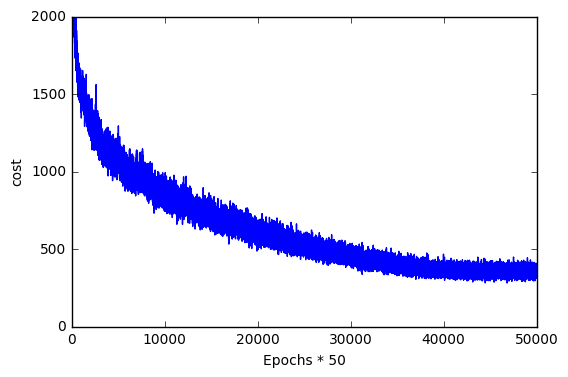

In [8]:
# 収束状況を可視化
plt.plot(range(len(nn.cost_)), nn.cost_)
plt.ylim([0, 2000])
plt.ylabel('cost')
plt.xlabel('Epochs * 50')
plt.show()

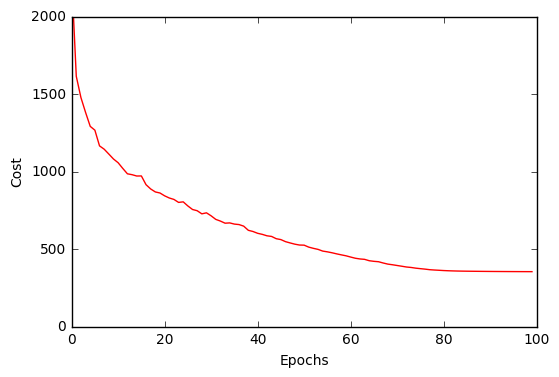

In [9]:
# 分割して平均を取り、よりなめらかな線で可視化
batches = np.array_split(range(len(nn.cost_)), 100)
cost_ary = np.array(nn.cost_)
cost_avgs = [np.mean(cost_ary[i]) for i in batches]
plt.plot(range(len(cost_avgs)), cost_avgs, color='red')
plt.ylim([0, 2000])
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.show()

In [10]:
# 予測の正解率を計算
y_train_pred = nn.predict(X_train)
acc = np.sum(y_train == y_train_pred, axis=0) / (X_train.shape[0] * 1.0)
print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 97.75%


In [11]:
# テストデータで汎化性能を確認
y_test_pred = nn.predict(X_test)
acc = np.sum(y_test == y_test_pred, axis=0) / (X_test.shape[0] * 1.0)
print('Test accuracy: %.2f%%' % (acc * 100))

Test accuracy: 95.87%


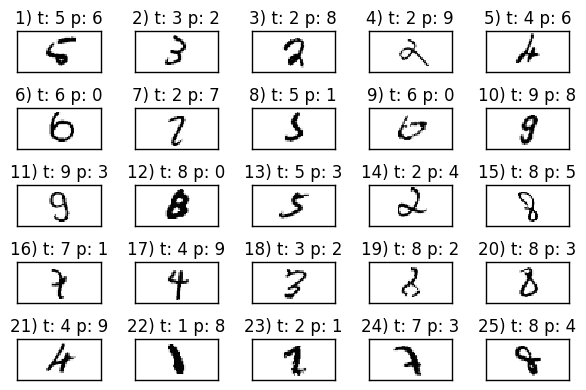

In [12]:
# 実際の画像と予測データを合わせて表示
miscl_img = X_test[y_test != y_test_pred][:25]
correct_lab = y_test[y_test != y_test_pred][:25]
miscl_lab = y_test_pred[y_test != y_test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = miscl_img[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title('%d) t: %d p: %d' % (i + 1, correct_lab[i], miscl_lab[i]))
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [17]:
nn = NeuralNetMLP(n_output=10,
                  n_features=X_train.shape[1],
                  n_hidden=10,
                  l2=0.0,
                  l1=0.0,
                  epochs=10,
                  eta=0.001,
                  alpha=0.0,
                  decrease_const=0.0,
                  shuffle=True,
                  minibatches=1,
                  random_state=1,
                  debug=True)

In [18]:
nn.fit(X_train[:5], y_train[:5], print_progress=False)

OK: 2.63656778037e-10
OK: 2.92544021079e-10
OK: 2.94979921068e-10
OK: 2.45040652631e-10
OK: 2.67675558719e-10
OK: 2.89850576755e-10
OK: 2.93101254662e-10
OK: 2.5695304248e-10
OK: 3.36827317181e-10
OK: 3.04264958241e-10


### kaggleのデータで実行してみる

In [8]:
import pandas as pd
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [9]:
X_train = train.ix[:, 1:].values
y_train = train.ix[:, 0].values
X_test = test.values

In [12]:
nn = NeuralNetMLP(n_output=10,
                  n_features=X_train.shape[1],
                  n_hidden=50,
                  l2=0.1,
                  l1=0.0,
                  epochs=1000,
                  eta=0.001,
                  alpha=0.001,
                  decrease_const=0.00001,
                  shuffle=True,
                  minibatches=50,
                  random_state=1)

In [13]:
nn.fit(X_train, y_train, print_progress=True)

Epoch: 1000/1000

In [10]:
# 予測の正解率を計算
y_train_pred = nn.predict(X_train)
acc = np.sum(y_train == y_train_pred, axis=0) / (X_train.shape[0] * 1.0)
print('Training accuracy: %.2f%%' % (acc * 100))

Training accuracy: 97.75%


In [17]:
# 結果を保存
submission = pd.DataFrame({
        'ImageId': test.index.values + 1,
        'Label': nn.predict(X_test).astype(int)
    })
submission.to_csv('result/predict_nn.csv', index=False)